In [5]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from memory_layers import HashingMemory, ModelEvaluator
from safetensors.torch import load_file
import pandas as pd
import matplotlib.pyplot as plt

# Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "Qwen/Qwen2.5-0.5B-Instruct"
hidden_dim = 896
layers_to_replace = [6, 12, 18]
num_samples = 50  # Small sample for quick testing, increase for full eval

In [6]:
# 1. Evaluate Base Model
print("Loading Base Model...")
base_model = AutoModelForCausalLM.from_pretrained(model_id, dtype=torch.float16).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id, dtype=torch.float16)

evaluator = ModelEvaluator(base_model, tokenizer, device=device)
base_results_qa = evaluator.evaluate_triviaqa(num_samples=num_samples)
base_results_hs = evaluator.evaluate_hellaswag(num_samples=num_samples)

print("\nBase Model Results:")
print(base_results_qa)
print(base_results_hs)


# Free up memory
del base_model
del evaluator
torch.cuda.empty_cache()

Loading Base Model...


`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'trivia_qa' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Evaluating on TriviaQA (validation, 50 samples)...


100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


TriviaQA Accuracy: 10.00%
Evaluating on HellaSwag (validation, 50 samples)...


100%|██████████| 50/50 [00:04<00:00, 10.31it/s]

HellaSwag Accuracy: 40.00%

Base Model Results:
0.1
0.4


In [10]:
# 2. Evaluate Fine-tuned Memory Model
print("Loading Fine-tuned Memory Model...")
model = AutoModelForCausalLM.from_pretrained(model_id, dtype=torch.float16).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id, dtype=torch.float16)

# Add memory layers
for idx in layers_to_replace:
    mem_layer = HashingMemory(
        input_dim=hidden_dim, output_dim=hidden_dim, mem_n_keys=128, mem_heads=4,
        mem_knn=16, mem_k_dim=256, mem_v_dim=-1, swilu_projection=True,
        value_fixed_lr=0.001, mem_share_values=False
    )
    model.model.layers[idx].mlp = mem_layer.to(device, dtype=model.dtype)

# Load weights
try:
    state_dict = load_file("./qwen_memory_final/model.safetensors")
except:
    state_dict = torch.load("./qwen_memory_final/pytorch_model.bin", weights_only=False)

model.load_state_dict(state_dict, strict=False)

evaluator = ModelEvaluator(model, tokenizer, device=device)
ft_results_qa = evaluator.evaluate_triviaqa(num_samples=num_samples)
ft_results_hs = evaluator.evaluate_hellaswag(num_samples=num_samples)

print("Fine-tune Model Results:")
print(ft_results_qa)
print(ft_results_hs)

Loading Fine-tuned Memory Model...


`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'trivia_qa' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Evaluating on TriviaQA (validation, 50 samples)...


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


TriviaQA Accuracy: 12.00%
Evaluating on HellaSwag (validation, 50 samples)...


100%|██████████| 50/50 [00:05<00:00,  8.88it/s]

HellaSwag Accuracy: 36.00%
Fine-tune Model Results:
0.12
0.36


In [7]:
# 2. Evaluate Fine-tuned Memory Model
print("Loading Fine-tuned Memory Model...")
model = AutoModelForCausalLM.from_pretrained(model_id, dtype=torch.float16).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id, dtype=torch.float16)

# Add memory layers
for idx in layers_to_replace:
    mem_layer = HashingMemory(
        input_dim=hidden_dim, output_dim=hidden_dim, mem_n_keys=128, mem_heads=4,
        mem_knn=16, mem_k_dim=256, mem_v_dim=-1, swilu_projection=True,
        value_fixed_lr=0.001, mem_share_values=False
    )
    model.model.layers[idx].mlp = mem_layer.to(device, dtype=model.dtype)

# Load weights
try:
    state_dict = load_file("./qwen_memory_sft/model.safetensors")
except:
    state_dict = torch.load("./qwen_memory_sft/pytorch_model.bin", weights_only=False)

model.load_state_dict(state_dict, strict=False)

evaluator = ModelEvaluator(model, tokenizer, device=device)
sft_results_qa = evaluator.evaluate_triviaqa(num_samples=num_samples)
sft_results_hs = evaluator.evaluate_hellaswag(num_samples=num_samples)

print("\Sparse Fine-tune Model Results:")
print(sft_results_qa)
print(sft_results_hs)

Loading Fine-tuned Memory Model...


<>:27: SyntaxWarning: invalid escape sequence '\S'
<>:27: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipykernel_830162/1720057309.py:27: SyntaxWarning: invalid escape sequence '\S'
  print("\Sparse Fine-tune Model Results:")
`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'trivia_qa' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Evaluating on TriviaQA (validation, 50 samples)...


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


TriviaQA Accuracy: 8.00%
Evaluating on HellaSwag (validation, 50 samples)...


100%|██████████| 50/50 [00:05<00:00,  9.21it/s]

HellaSwag Accuracy: 36.00%
\Sparse Fine-tune Model Results:
0.08
0.36


In [8]:
# 2. Evaluate Fine-tuned Memory Model
print("Loading Fine-tuned Memory Model...")
model = AutoModelForCausalLM.from_pretrained(model_id, dtype=torch.float16).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id, dtype=torch.float16)

# Add memory layers
for idx in layers_to_replace:
    mem_layer = HashingMemory(
        input_dim=hidden_dim, output_dim=hidden_dim, mem_n_keys=128, mem_heads=4,
        mem_knn=16, mem_k_dim=256, mem_v_dim=-1, swilu_projection=True,
        value_fixed_lr=0.001, mem_share_values=False
    )
    model.model.layers[idx].mlp = mem_layer.to(device, dtype=model.dtype)

# Load weights
try:
    state_dict = load_file("./qwen_memory_ft/model.safetensors")
except:
    state_dict = torch.load("./qwen_memory_ft/pytorch_model.bin", weights_only=False)

model.load_state_dict(state_dict, strict=False)

evaluator = ModelEvaluator(model, tokenizer, device=device)
fft_results_qa = evaluator.evaluate_triviaqa(num_samples=num_samples)
fft_results_hs = evaluator.evaluate_hellaswag(num_samples=num_samples)

print("\Full Fine-tune Model Results:")
print(fft_results_qa)
print(fft_results_hs)

<>:27: SyntaxWarning: invalid escape sequence '\F'
<>:27: SyntaxWarning: invalid escape sequence '\F'
/tmp/ipykernel_830162/566988531.py:27: SyntaxWarning: invalid escape sequence '\F'
  print("\Full Fine-tune Model Results:")


Loading Fine-tuned Memory Model...


`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'trivia_qa' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Evaluating on TriviaQA (validation, 50 samples)...


100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


TriviaQA Accuracy: 2.00%
Evaluating on HellaSwag (validation, 50 samples)...


100%|██████████| 50/50 [00:05<00:00,  9.16it/s]

HellaSwag Accuracy: 28.00%
\Full Fine-tune Model Results:
0.02
0.28



Comparison Table:
                    0
Base              0.1
Memory-Augmented  0.0


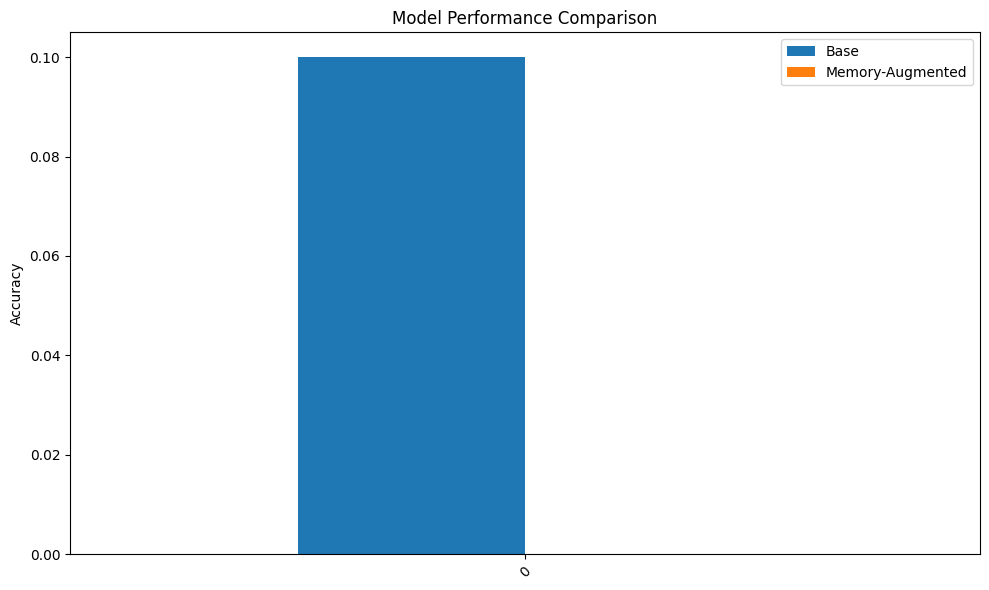

In [4]:
# 3. Compare Results
df = pd.DataFrame([base_results, ft_results], index=['Base', 'Memory-Augmented'])
print("\nComparison Table:")
print(df)

# Plot
df.T.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Graph saved as combined_loss_curve.png


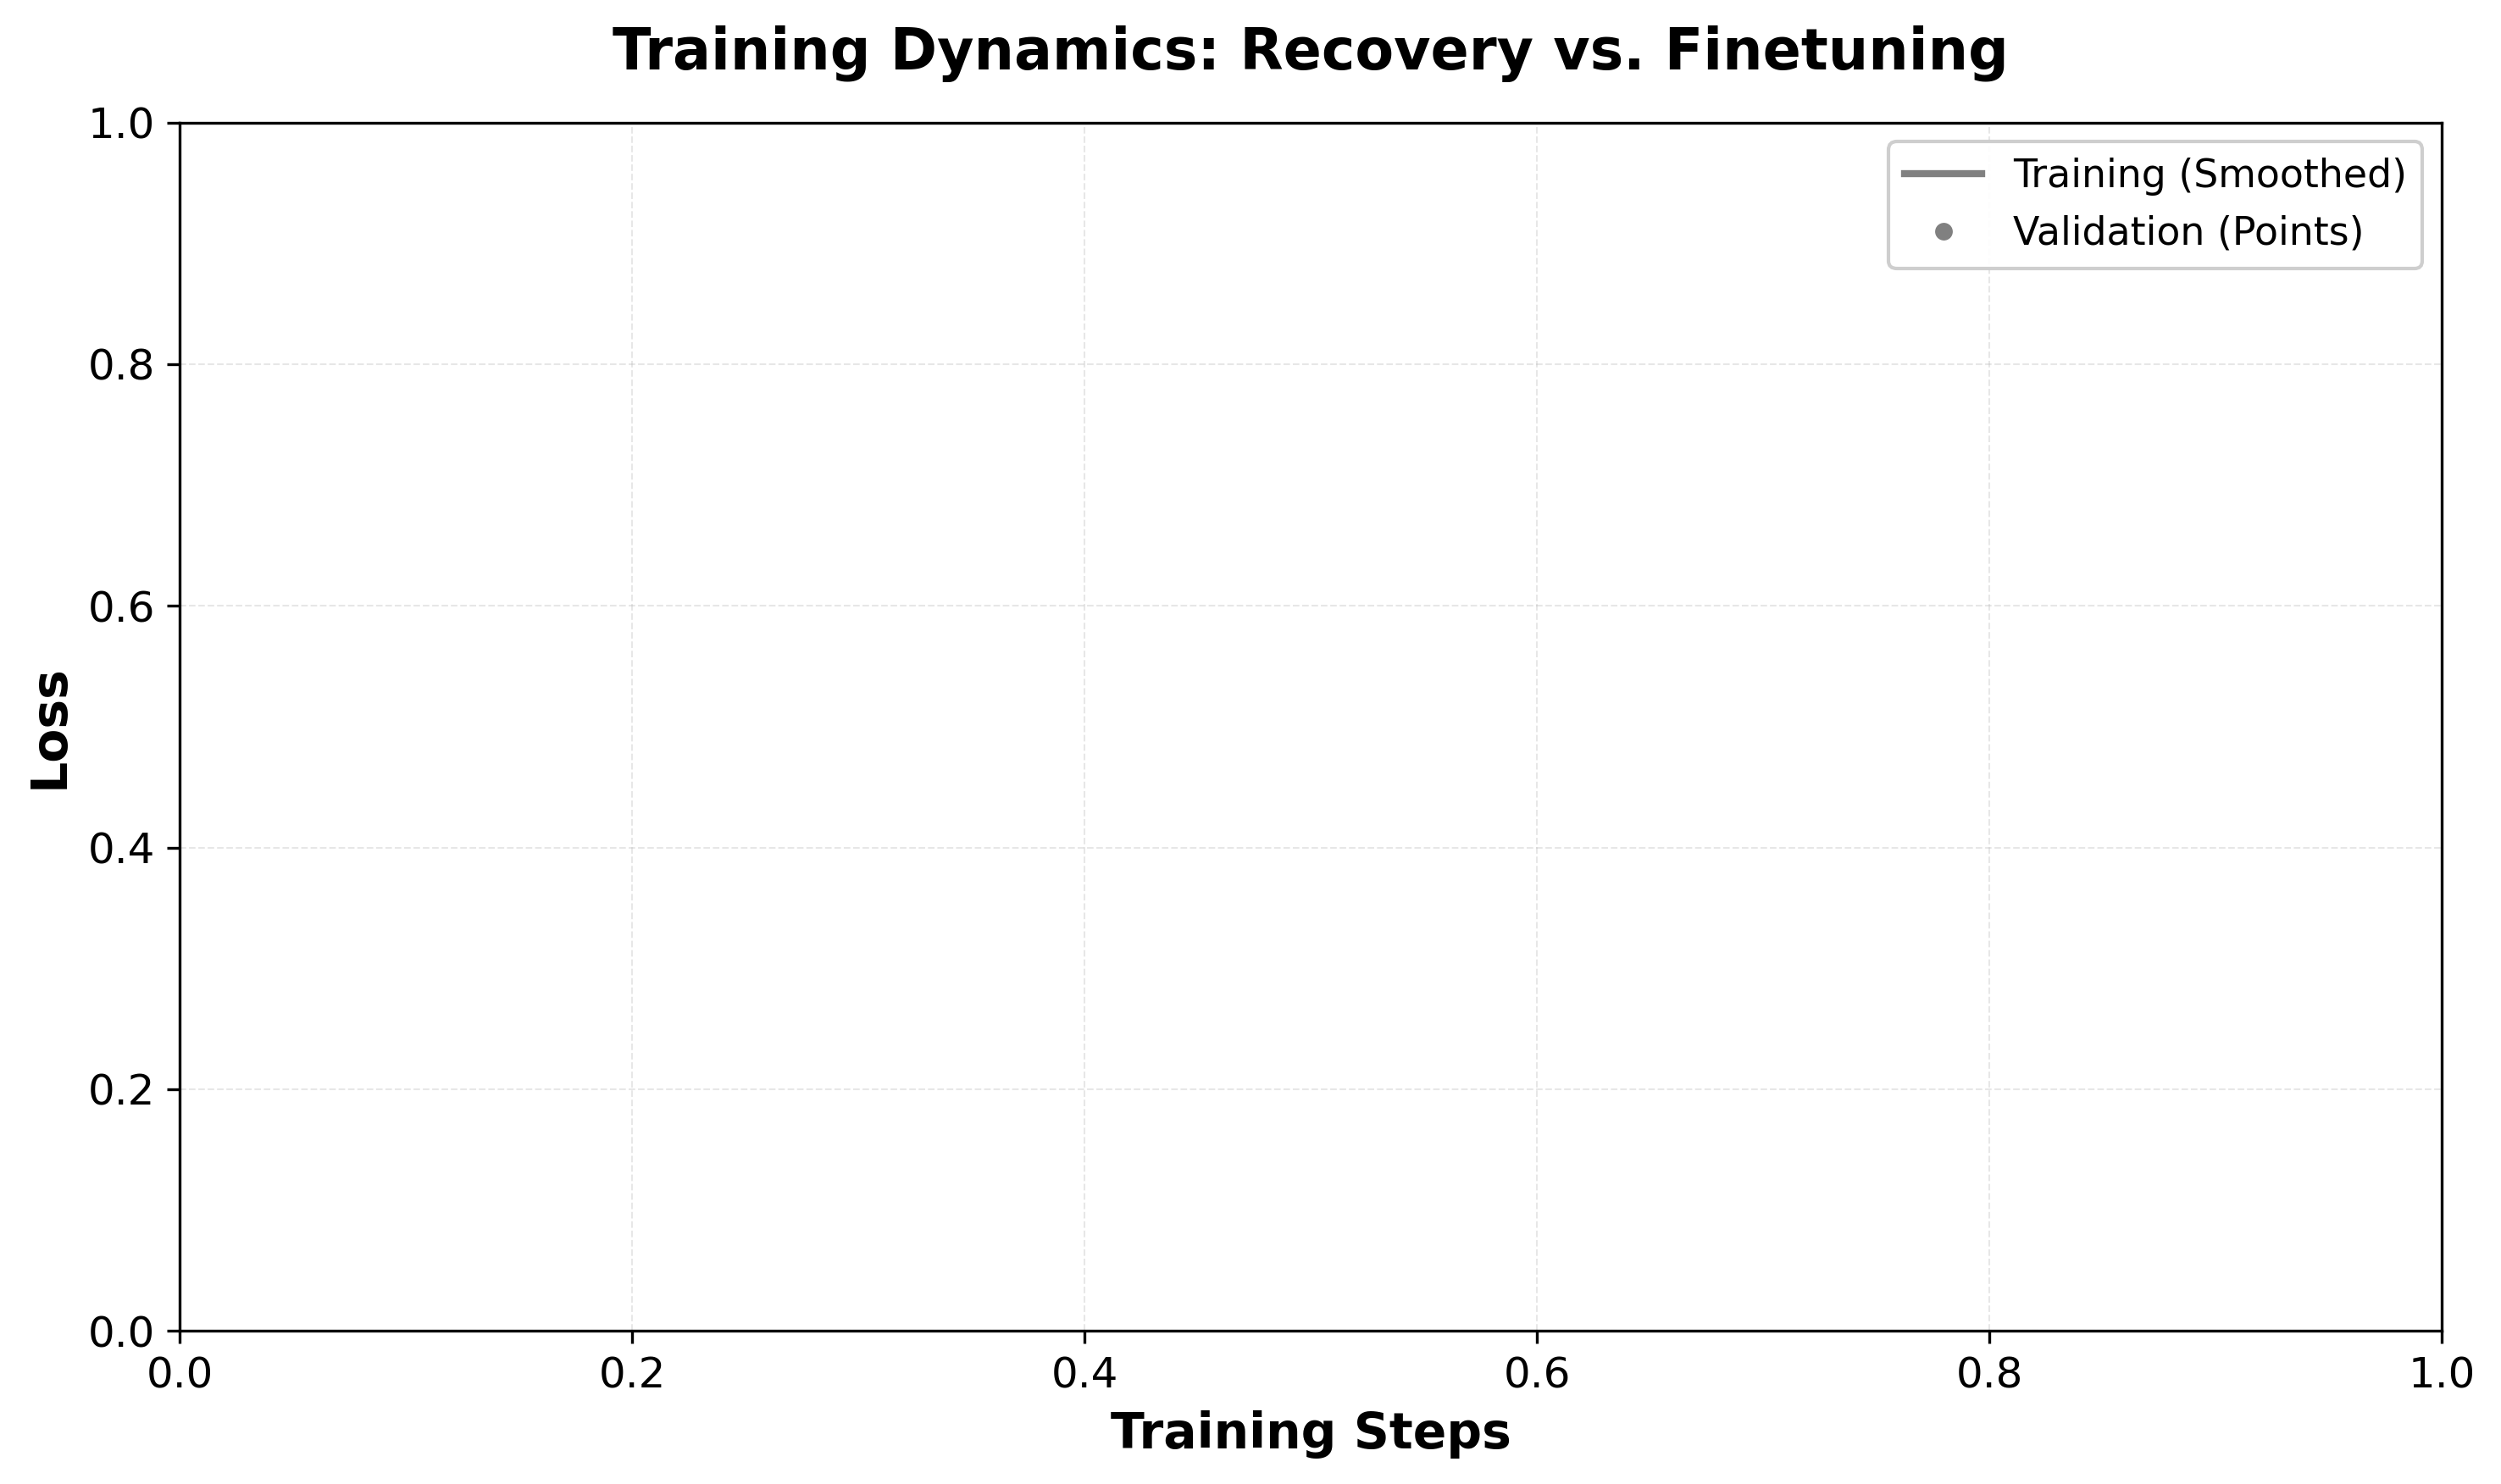

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage import uniform_filter1d
import os

# ==========================================
# Configuration
# ==========================================
# File paths (Adjust these if your folder structure is different)
files = {
    'Base (Recovery)': {
        'train': '/base_finetuning_train_losses.csv',
        'eval': '/base_finetuning_eval_losses.csv',
        'color': '#1f77b4', # Blue
    },
    'Sparse Finetuning': {
        'train': '/sparse_finetuning_train_losses.csv',
        'eval': '/sparse_finetuning_eval_losses.csv',
        'color': '#2ca02c', # Green
    },
    'Full Finetuning': {
        'train': '/full_finetuning_train_losses.csv',
        'eval': '/full_finetuning_eval_losses.csv',
        'color': '#d62728', # Red
    }
}

# Style settings (Matching your poster style)
plt.rcParams['font.family'] = 'DejaVu Sans' # Or 'Arial' if installed
plt.rcParams['font.size'] = 12

# Create figure
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# ==========================================
# Data Loading & Plotting Loop
# ==========================================

for label, config in files.items():
    color = config['color']
    
    # 1. Load Training Data
    # Assuming CSV has headers like 'step', 'loss'
    try:
        if os.path.exists(config['train']):
            df_train = pd.read_csv(config['train'])
            # Normalize column names if needed (e.g., strip whitespace)
            df_train.columns = [c.strip().lower() for c in df_train.columns]
            
            # Extract data
            steps = df_train['step']
            losses = df_train['loss']
            
            # Plot Raw (faint)
            ax.plot(steps, losses, alpha=0.15, color=color, linewidth=1)
            
            # Plot Smoothed (Solid)
            if len(losses) > 10:
                window_size = min(11, len(losses) // 3)
                smoothed_loss = uniform_filter1d(losses, size=window_size)
                ax.plot(steps, smoothed_loss, label=f'{label}', 
                        color=color, linewidth=2.5)
            else:
                ax.plot(steps, losses, label=f'{label}', 
                        color=color, linewidth=2.5)
                
    except Exception as e:
        print(f"Could not plot training for {label}: {e}")

    # 2. Load Eval Data
    try:
        if os.path.exists(config['eval']):
            df_eval = pd.read_csv(config['eval'])
            df_eval.columns = [c.strip().lower() for c in df_eval.columns]
            
            # Check for common eval column names
            loss_col = 'eval_loss' if 'eval_loss' in df_eval.columns else 'loss'
            
            eval_steps = df_eval['step']
            eval_losses = df_eval[loss_col]
            
            # Plot Eval (Dots)
            # We don't add a label here to avoid cluttering the legend
            ax.plot(eval_steps, eval_losses, color=color, 
                    marker='o', markersize=6, linestyle='None', 
                    markeredgecolor='white', markeredgewidth=1.5, alpha=0.9)
            
    except Exception as e:
        print(f"Could not plot eval for {label}: {e}")

# ==========================================
# Formatting
# ==========================================

ax.set_xlabel('Training Steps', fontsize=14, fontweight='bold')
ax.set_ylabel('Loss', fontsize=14, fontweight='bold')
ax.set_title('Training Dynamics: Recovery vs. Finetuning', fontsize=16, fontweight='bold', pad=15)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Custom Legend
# We create a custom legend to explain the lines vs dots
from matplotlib.lines import Line2D

# Get existing handles (the colored lines)
handles, labels = ax.get_legend_handles_labels()

# Add "Style" legend entries manually
handles.append(Line2D([0], [0], color='gray', lw=2, label='Training (Smoothed)'))
handles.append(Line2D([0], [0], color='gray', marker='o', linestyle='None', 
                      markeredgecolor='white', label='Validation (Points)'))

# Plot legend
ax.legend(handles=handles, loc='upper right', fontsize=11, framealpha=0.95, fancybox=True)

# Adjust margins
plt.tight_layout()

# Save
plt.savefig('combined_loss_curve.png', dpi=300, bbox_inches='tight')
plt.savefig('combined_loss_curve.pdf', dpi=300, bbox_inches='tight')

print("Graph saved as combined_loss_curve.png")
plt.show()